
# Waffle Charts, Word Clouds, and Regression Plots

In [ ]:
!pip install matplotlib openpyxl==3.1.0 numpy pandas

In [ ]:
url='https://raw.githubusercontent.com/nluninja/text-mining-dataviz/main/5.%20Data%20Visualization/Canada.xlsx'

In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

In [2]:
df_can = pd.read_excel(
    url,
    sheet_name='Canada by Citizenship',
    skiprows=range(20),
    skipfooter=2,
    engine='openpyxl'
    )

df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


In [3]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

years = list(map(str, range(1980, 2014)))

df_can['Total'] = df_can[[*years]].sum(axis=1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


<ipython-input-3-92cc0d23d11f>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_can['Total'] =  df_can.sum (axis = 1)


In [4]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.3.4


## Waffle Charts

<div style="border:1px solid green; padding: 10px">
<font color='green' style="font-weight:bold">
A `waffle chart` is an interesting visualization that is normally created to display progress toward goals.
    
It is commonly an effective option when you are trying to add interesting visualization features to a visual that consists mainly of cells, such as an Excel dashboard.
</font>
</div>

<img src="images/waffle.png"/>

Let's revisit the previous case study about Denmark, Norway, and Sweden.


In [5]:
# let's create a new dataframe for these three countries 
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]

# let's take a look at our dataframe
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


Unfortunately, unlike R, `waffle` charts are not built into any of the Python visualization libraries. Therefore, we will learn how to create them from scratch.


**Step 1.** The first step into creating a waffle chart is determing the proportion of each category with respect to the total.


In [6]:
# compute the proportion of each category with respect to the total
total_values = df_dsn['Total'].sum()
category_proportions = df_dsn['Total'] / total_values

# print out proportions
pd.DataFrame({"Category Proportion": category_proportions})

,Category Proportion
Country,
Denmark,0.322557
Norway,0.192409
Sweden,0.485034


**Step 2.** The second step is defining the overall size of the `waffle` chart.


In [7]:
width = 40 # width of chart
height = 10 # height of chart

total_num_tiles = width * height # total number of tiles

print(f'Total number of tiles is {total_num_tiles}.')

Total number of tiles is 400.


**Step 3.** The third step is using the proportion of each category to determe it respective number of tiles


In [8]:
# compute the number of tiles for each category
tiles_per_category = (category_proportions * total_num_tiles).round().astype(int)

# print out number of tiles per category
pd.DataFrame({"Number of tiles": tiles_per_category})

,Number of tiles
Country,
Denmark,129
Norway,77
Sweden,194


Based on the calculated proportions, Denmark will occupy 129 tiles of the `waffle` chart, Norway will occupy 77 tiles, and Sweden will occupy 194 tiles.


**Step 4.** The fourth step is creating a matrix that resembles the `waffle` chart and populating it.


In [9]:
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width), dtype = np.uint)

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

Waffle chart populated!


Let's take a peek at how the matrix looks like.


In [10]:
waffle_chart

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

As expected, the matrix consists of three categories and the total number of each category's instances matches the total number of tiles allocated to each category.


**Step 5.** Map the `waffle` chart matrix into a visual using matshow that displays an array as a matrix in a new figure window.


<Figure size 432x288 with 0 Axes>

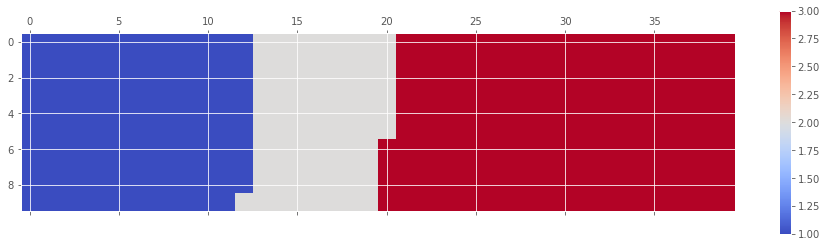

In [11]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()
plt.show()

**Step 6.** Prettify the chart.


<Figure size 432x288 with 0 Axes>

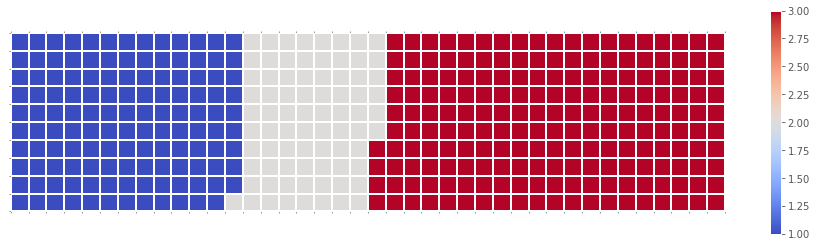

In [12]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])
plt.show()

**Step 7.** Create a legend and add it to chart.


<Figure size 432x288 with 0 Axes>

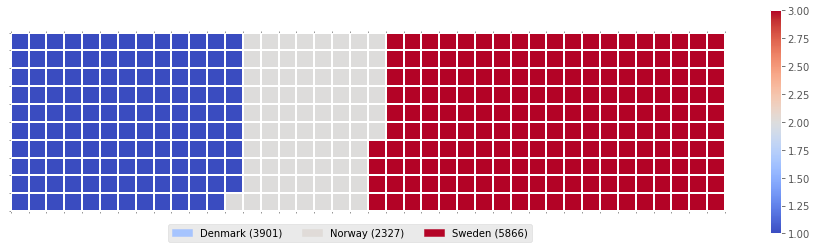

In [13]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

# compute cumulative sum of individual categories to match color schemes between chart and legend
values_cumsum = np.cumsum(df_dsn['Total'])
total_values = values_cumsum[len(values_cumsum) - 1]

# create legend
legend_handles = []
for i, category in enumerate(df_dsn.index.values):
    label_str = category + ' (' + str(df_dsn['Total'][i]) + ')'
    color_val = colormap(float(values_cumsum[i])/total_values)
    legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

# add legend to chart
plt.legend(handles=legend_handles,
           loc='lower center', 
           ncol=len(df_dsn.index.values),
           bbox_to_anchor=(0., -0.2, 0.95, .1)
          )
plt.show()

In [14]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )
    plt.show()

Now to create a `waffle` chart, all we have to do is call the function `create_waffle_chart`. Let's define the input parameters:


In [15]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Total'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

And now let's call our function to create a `waffle` chart.


Total number of tiles is 400
Denmark: 129
Norway: 77
Sweden: 194


<Figure size 432x288 with 0 Axes>

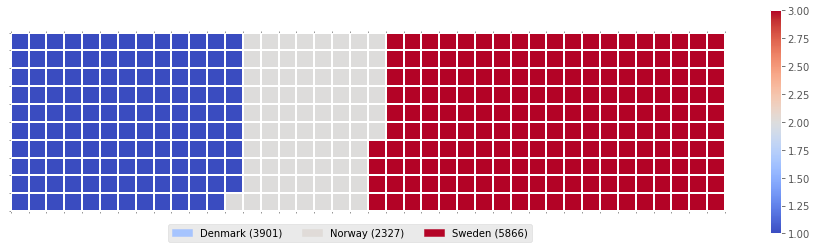

In [16]:
create_waffle_chart(categories, values, height, width, colormap)

# Word Clouds <a id="8"></a>

<div style="border:1px solid green; padding: 10px">
<font color='green' style="font-weight:bold">`Word` clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.</font></div>


Luckily, a Python package already exists in Python for generating `word` clouds. The package, called `word_cloud` was developed by **Andreas Mueller**. You can learn more about the package by following this [link](https://github.com/amueller/word_cloud/).

Let's use this package to learn how to generate a word cloud for a given text document.


First, let's install the package.


In [17]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

Let's try to analyze a short novel written by **Lewis Carroll** titled *Alice's Adventures in Wonderland*. Let's go ahead and download a *.txt* file of the novel.


In [ ]:
url_novel = 

In [18]:
import urllib

with open(url_novel,encoding='utf-8') as f:
    alice_novel = f.read()

Next, let's use the stopwords that we imported from `word_cloud`. We use the function *set* to remove any redundant stopwords.


In [19]:
stopwords = set(STOPWORDS)

Create a word cloud object and generate a word cloud. For simplicity, let's generate a word cloud using only the first 2000 words in the novel.


In [20]:
# instantiate a word cloud object
alice_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
alice_wc.generate(alice_novel)

Awesome! Now that the `word` cloud is created, let's visualize it.


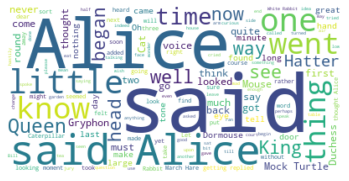

In [21]:
# display the word cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

So in the first 2000 words in the novel, the most common words are **Alice**, **said**, **little**, **Queen**, and so on. Let's resize the cloud so that we can see the less frequent words a little better.


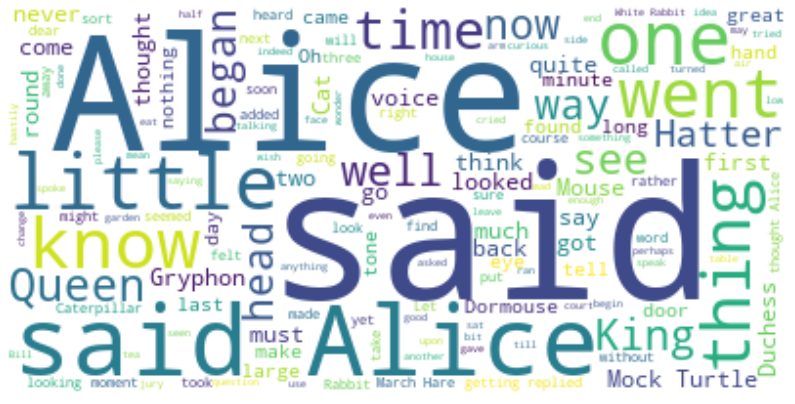

In [22]:
fig = plt.figure(figsize=(14, 18))

# display the cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

So let's add **said** to our stopwords and re-generate the cloud.


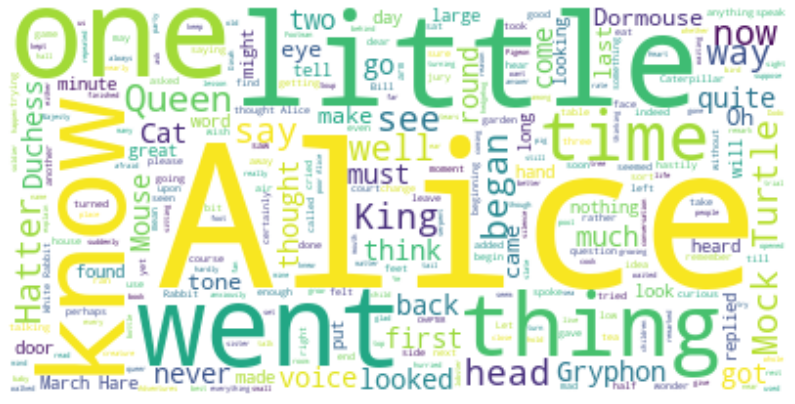

In [23]:
stopwords.add('said') # add the words said to stopwords

# re-generate the word cloud
alice_wc.generate(alice_novel)

# display the cloud
fig = plt.figure(figsize=(14, 18))

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Excellent! This looks really interesting! Another cool thing you can implement with the `word_cloud` package is superimposing the words onto a mask of any shape. Let's use a mask of Alice and her rabbit. We already created the mask for you, so let's go ahead and download it and call it *alice_mask.png*.


In [24]:
# save mask to alice_mask
alice_mask = np.array(Image.open('images/alice_mask.png'))

Let's take a look at how the mask looks like.


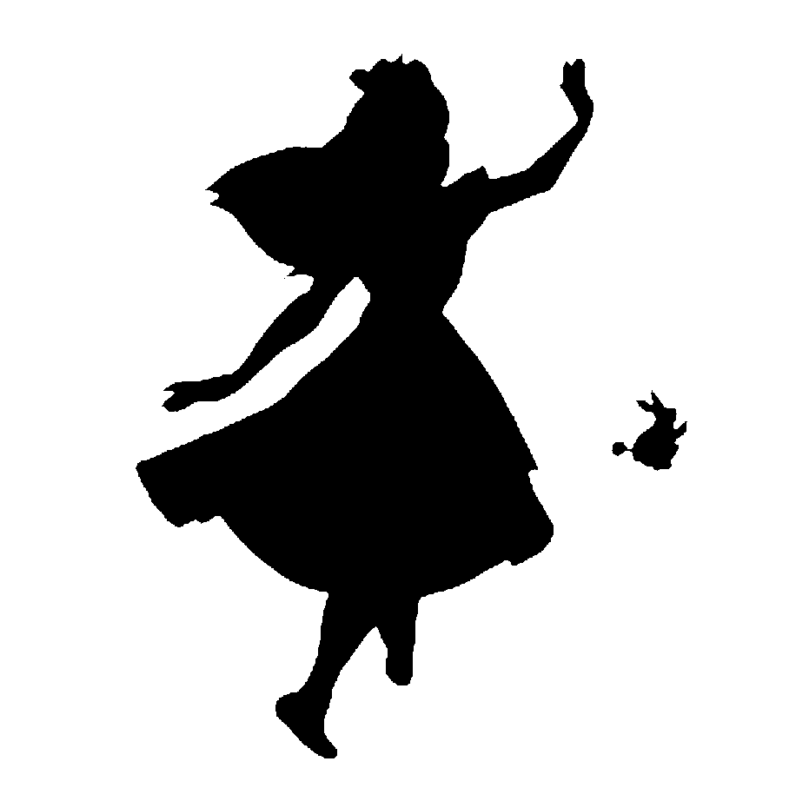

In [25]:
fig = plt.figure(figsize=(14, 18))

plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

Shaping the `word` cloud according to the mask is straightforward using `word_cloud` package. For simplicity, we will continue using the first 2000 words in the novel.


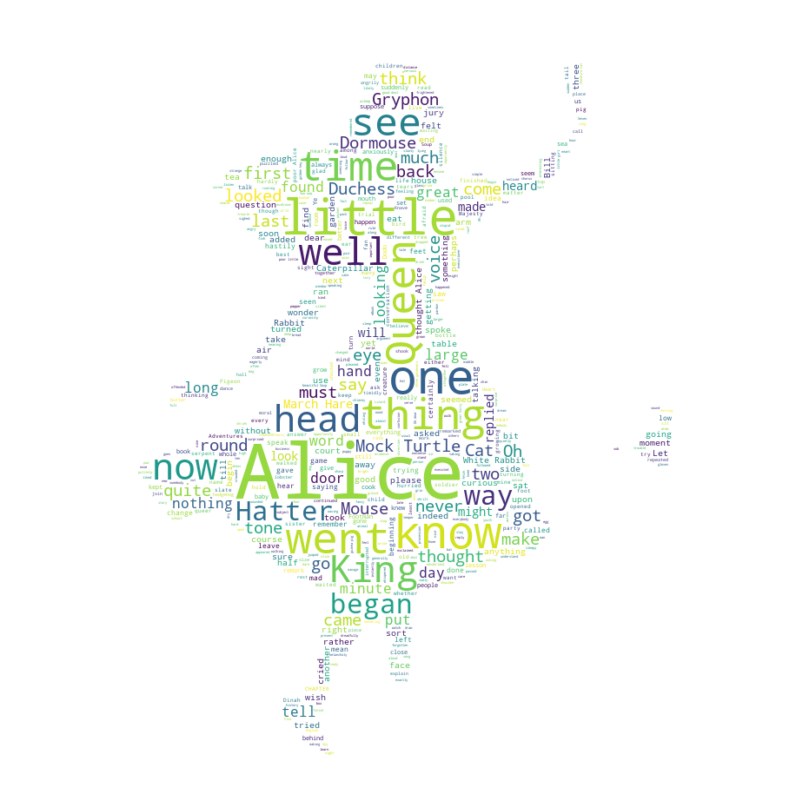

In [26]:
# instantiate a word cloud object
alice_wc = WordCloud(background_color='white', max_words=2000, mask=alice_mask, stopwords=stopwords)

# generate the word cloud
alice_wc.generate(alice_novel)

# display the word cloud
fig = plt.figure(figsize=(14, 18))

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Regression Plots <a id="10"></a>


Regression plots as the name suggests creates a regression line between 2 parameters and helps to visualize their linear relationships. 

Let's first install *seaborn*


In [27]:
# import library
import seaborn as sns

Create a new dataframe that stores that total number of landed immigrants to Canada per year from 1980 to 2013.


In [28]:
# we can use the sum() method to get the total population per year
df_tot = pd.DataFrame(df_can[years].sum(axis=0))

# change the years to type float (useful for regression later on)
df_tot.index = map(float, df_tot.index)

# reset the index to put in back in as a column in the df_tot dataframe
df_tot.reset_index(inplace=True)

# rename columns
df_tot.columns = ['year', 'total']

# view the final dataframe
df_tot.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


With *seaborn*, generating a regression plot is as simple as calling the **regplot** function.


<AxesSubplot:xlabel='year', ylabel='total'>

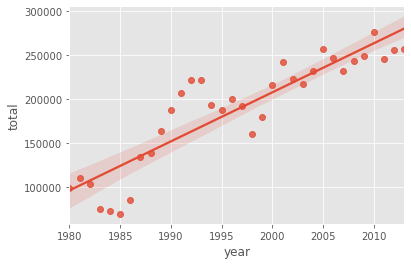

In [29]:
sns.regplot(x='year', y='total', data=df_tot)

You can also customize the color of the scatter plot and regression line. Let's change the color to green.



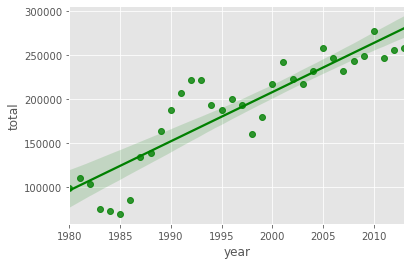

In [30]:
sns.regplot(x='year', y='total', data=df_tot, color='green')

plt.show()

You can always customize the marker shape, so instead of circular markers, let's use `+`.


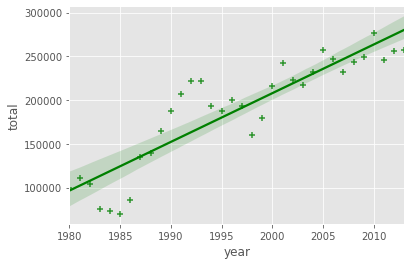

In [31]:
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')
plt.show()

Let's blow up the plot a little so that it is more appealing to the sight.


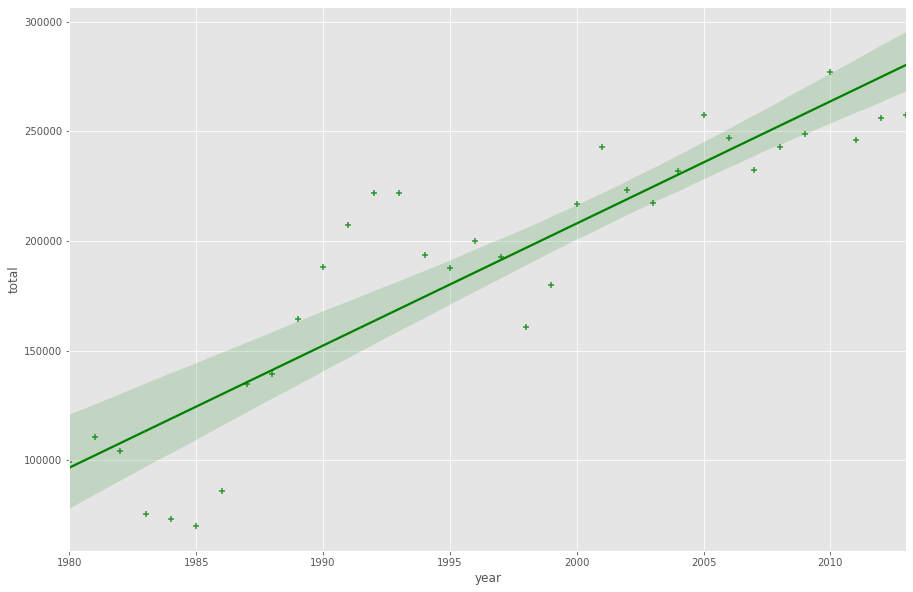

In [32]:
plt.figure(figsize=(15, 10))
sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')
plt.show()

And let's increase the size of markers so they match the new size of the figure, and add a title and x- and y-labels.


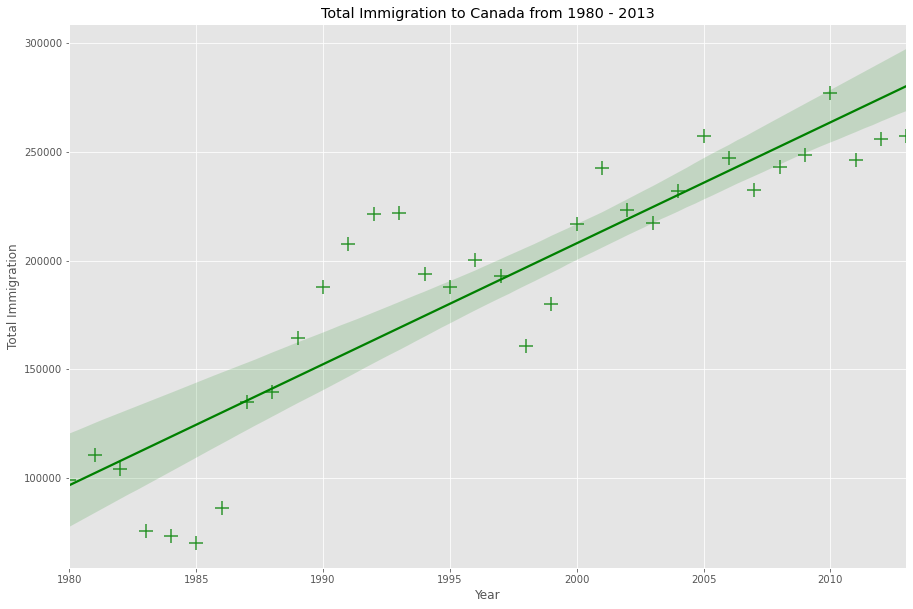

In [33]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})

ax.set(xlabel='Year', ylabel='Total Immigration') # add x- and y-labels
ax.set_title('Total Immigration to Canada from 1980 - 2013') # add title
plt.show()

And finally increase the font size of the tickmark labels, the title, and the x- and y-labels so they don't feel left out!


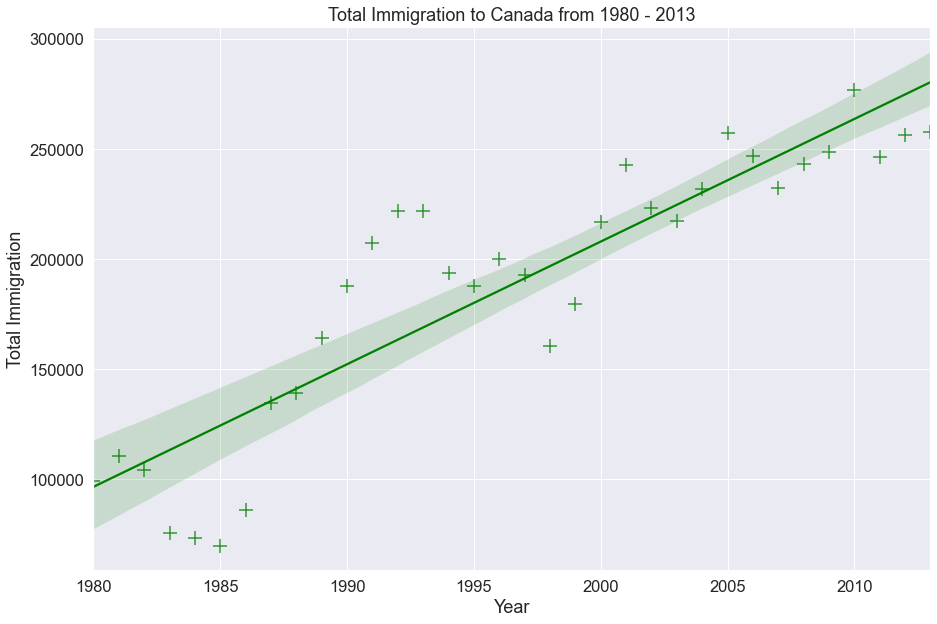

In [34]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')
plt.show()

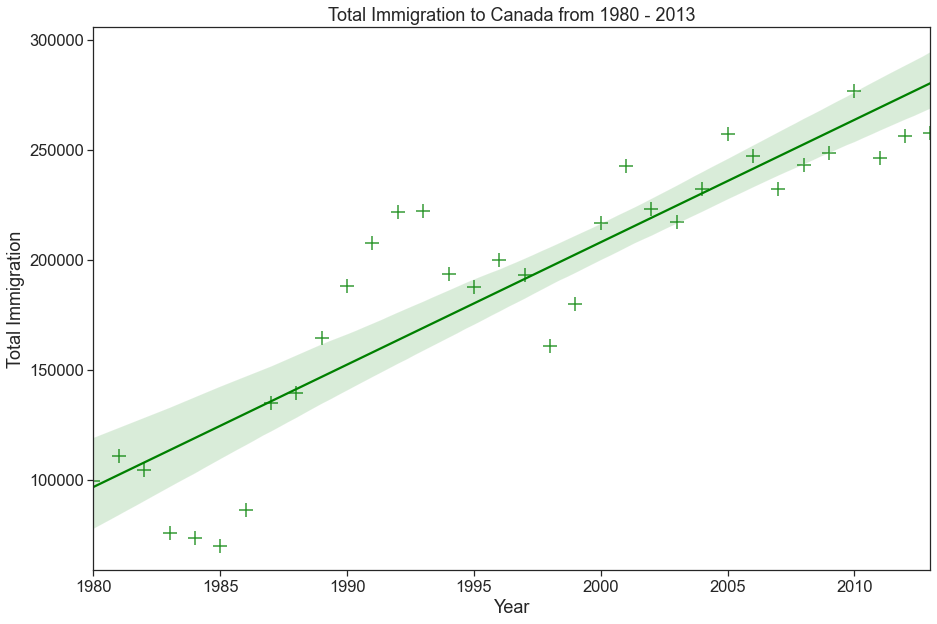

In [35]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('ticks')  # change background to white background

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')
plt.show()

Or to a white background with gridlines.


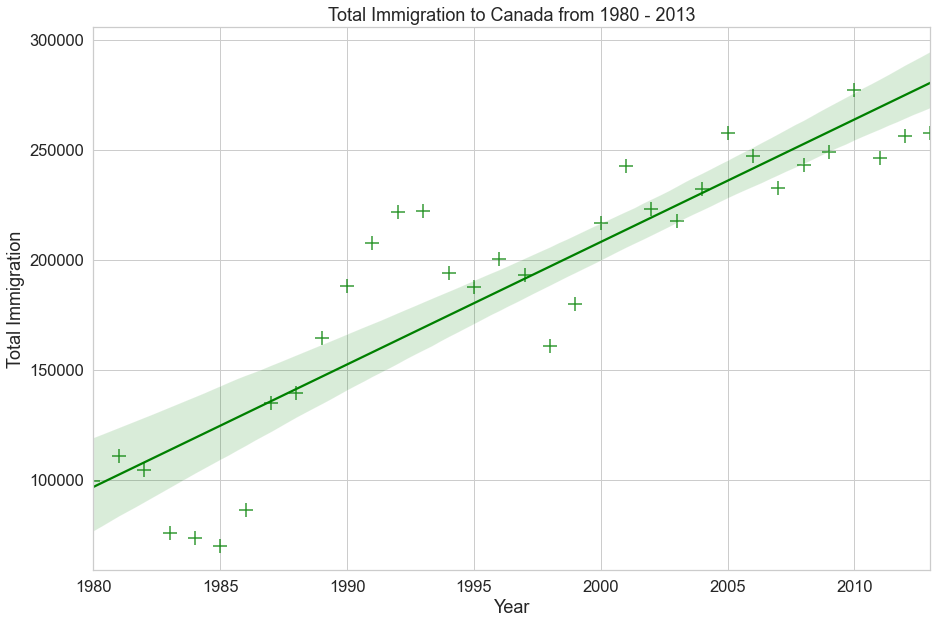

In [36]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')
plt.show()